In [7]:
import json
from pathlib import Path
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns 
from sentence_transformers import SentenceTransformer
import umap.umap_ as umap
import hdbscan
from sklearn.metrics.pairwise import cosine_similarity


In [37]:
# Paths

data_path = Path("../../data/short-raw-refs-abs")
processed_abstracts_path = Path("../../data/processed/abstracts")
save_path = processed_abstracts_path / "umap_hdbscan"


# Ensure directories exist
for p in [data_path, processed_abstracts_path, save_path]:
    p.mkdir(parents=True, exist_ok=True)

print("All directories verified/created.")

All directories verified/created.


In [3]:
# Load abstracts dataset

abstracts_path = processed_abstracts_path / "abstracts.csv"
df = pd.read_csv(abstracts_path)

print(f"Loaded {len(df)} abstracts from {df['query_id'].nunique()} queries.")
df.head()

Loaded 44071 abstracts from 19 queries.


,query_id,eid,doi,title,abstract,clean_abs
0,ml_anomaly_detection_production,2-s2.0-105018574505,10.1016/j.measurement.2025.119261,Distillation anomaly and fault detection based...,© 2025 The Author(s)The detection of anomalies...,The detection of anomalies in production proce...
1,ml_anomaly_detection_production,2-s2.0-105019192533,10.1007/978-3-032-06118-8_30,From Lab to Factory: Pitfalls and Guidelines f...,"© The Author(s), under exclusive license to Sp...",", under exclusive license to Springer Nature S..."
2,ml_anomaly_detection_production,2-s2.0-105016669957,10.1007/978-3-032-04200-2_5,Intelligent Defect Detection for Manufacturing...,"© The Author(s), under exclusive license to Sp...",", under exclusive license to Springer Nature S..."
3,ml_anomaly_detection_production,2-s2.0-85218693791,10.1038/s41598-025-90810-w,Hybrid machine learning framework for predicti...,© The Author(s) 2025.The critical necessity fo...,2025.The critical necessity for sophisticated ...
4,ml_anomaly_detection_production,2-s2.0-105018301117,10.1016/j.comnet.2025.111753,BGP anomaly detection using the raw internet t...,© 2025 The AuthorsThe Border Gateway Protocol ...,© 2025 The AuthorsThe Border Gateway Protocol ...


In [4]:
model = SentenceTransformer("sentence-transformers/all-mpnet-base-v2")

In [ ]:
# Embed all abstracts in batches

texts = df["clean_abs"].astype(str).tolist()
batch_size = 256

embeddings = []

for start in tqdm(range(0, len(texts), batch_size), desc="Embedding abstracts"):
    batch = texts[start:start+batch_size]
    batch_emb = model.encode(
        batch,
        convert_to_numpy=True,
        normalize_embeddings=True,
        batch_size=len(batch)
    )
    embeddings.append(batch_emb)

embeddings = np.vstack(embeddings)
print("Embedding matrix shape:", embeddings.shape)


Embedding abstracts: 100%|██████████| 173/173 [04:09<00:00,  1.44s/it]

Embedding matrix shape: (44071, 768)


In [38]:
# Save embeddings to .npy file
emb_path = save_path / "abstract_embeddings.npy"
np.save(emb_path, embeddings)
print("Saved embeddings to:", emb_path)


Saved embeddings to: ../../data/processed/abstracts/umap_hdbscan/abstract_embeddings.npy


In [40]:
# Load embeddings back
embeddings = np.load(save_path / "abstract_embeddings.npy")

In [41]:
# Reduce embedding dimensionality with UMAP

umap_model = umap.UMAP(
    n_neighbors=30,
    min_dist=0.1,
    n_components=2,
    metric="cosine",
    random_state=42
)

umap_coords = umap_model.fit_transform(embeddings)
df["umap_x"] = umap_coords[:,0]
df["umap_y"] = umap_coords[:,1]

print("UMAP projection complete.")


/cluster/home/mbergst/.venvs/ml-catalogue/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


UMAP projection complete.


In [42]:
# Cluster UMAP-projected data using HDBSCAN

clusterer = hdbscan.HDBSCAN(
    min_cluster_size=200,
    min_samples=20,
    metric='euclidean',
    cluster_selection_method='leaf'
)

cluster_labels = clusterer.fit_predict(umap_coords)
df["cluster_id"] = cluster_labels

print("Clusters found:", df["cluster_id"].nunique(), "(includes -1 noise)")
df["cluster_id"].value_counts().sort_index().head(20)


/cluster/home/mbergst/.venvs/ml-catalogue/lib/python3.11/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/cluster/home/mbergst/.venvs/ml-catalogue/lib/python3.11/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Clusters found: 51 (includes -1 noise)


cluster_id
-1     19130
 0      1589
 1       752
 2       320
 3       256
 4       587
 5       421
 6       259
 7       270
 8       366
 9      1206
 10      402
 11      930
 12      470
 13      234
 14     1013
 15     1030
 16      558
 17      494
 18      320
Name: count, dtype: int64

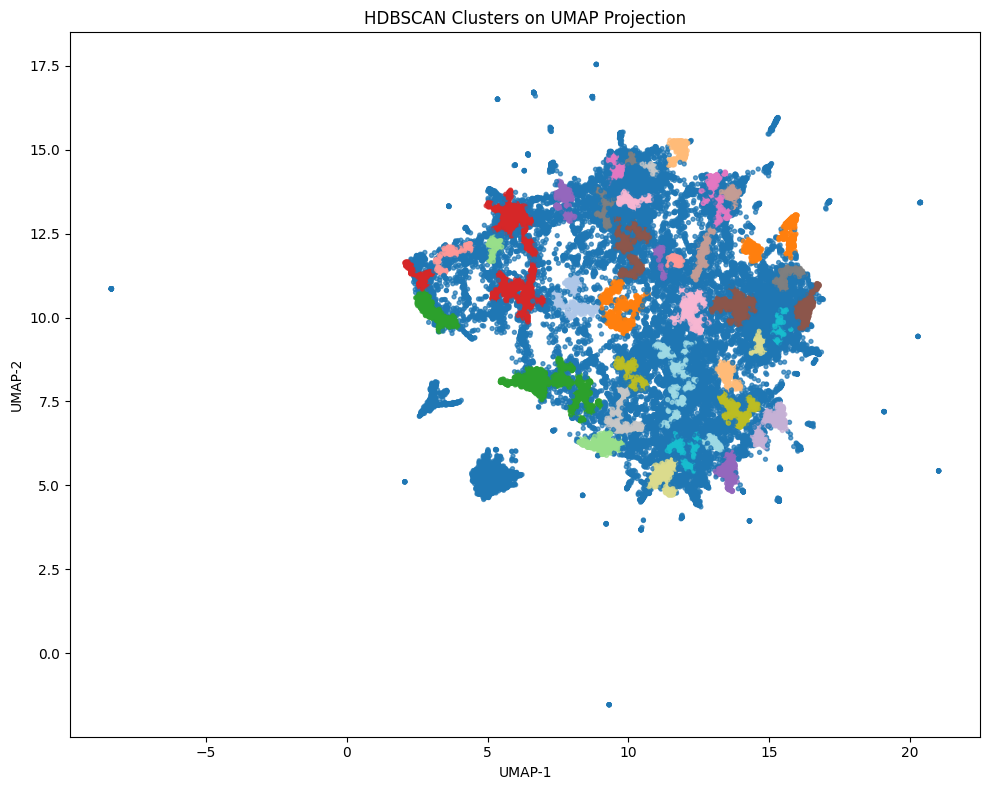

In [43]:
# Scatter plot of clusters in UMAP space

plt.figure(figsize=(10,8))
scatter = plt.scatter(
    df["umap_x"],
    df["umap_y"],
    c=df["cluster_id"],
    cmap="tab20",
    s=8,
    alpha=0.7
)
plt.title("HDBSCAN Clusters on UMAP Projection")
plt.xlabel("UMAP-1")
plt.ylabel("UMAP-2")
plt.tight_layout()
plt.show()


In [33]:
# Show top queries per cluster (themes)
cluster_summary = (
    df.groupby(["cluster_id", "query_id"])
      .size()
      .reset_index(name="count")
      .sort_values(["cluster_id", "count"], ascending=[True, False])
)

cluster_summary.head(20)


,cluster_id,query_id,count
4,-1,ml_manufacturing,8216
12,-1,ml_production_optimization,2290
7,-1,ml_predictive_maintenance,2242
8,-1,ml_process_control,1449
5,-1,ml_planning_production,707
10,-1,ml_product_design,598
16,-1,ml_rul,464
18,-1,ml_sustainability_product,453
3,-1,ml_inservice_monitoring,402
15,-1,ml_robotics_production,395


In [34]:
# Summary: cluster sizes and % of noise
cluster_counts = df["cluster_id"].value_counts()
noise_pct = 100 * cluster_counts.get(-1, 0) / len(df)

print("Cluster count summary:")
print(cluster_counts.head(10))
print(f"\nNoise articles: {noise_pct:.1f}%")


Cluster count summary:
cluster_id
-1     19130
 0      1589
 9      1206
 15     1030
 14     1013
 11      930
 25      785
 1       752
 42      701
 26      688
Name: count, dtype: int64

Noise articles: 43.4%


In [17]:
# Show one representative abstract per cluster (closest to centroid)

cluster_reps = []

for cid in sorted(df["cluster_id"].unique()):
    if cid == -1:
        continue

    idxs = df[df["cluster_id"] == cid].index
    if len(idxs) == 0:
        continue

    emb_sub = embeddings[idxs]
    centroid = emb_sub.mean(axis=0, keepdims=True)
    sims = cosine_similarity(emb_sub, centroid).flatten()
    rep_idx = idxs[sims.argmax()]

    cluster_reps.append(df.loc[rep_idx, ["cluster_id", "query_id", "title", "clean_abs"]])

pd.DataFrame(cluster_reps).head(10)


,cluster_id,query_id,title,clean_abs
6619,0,ml_manufacturing,A Deep Learning Method for the Security Vulner...,© King Fahd University of Petroleum & Minerals...
10452,1,ml_manufacturing,Machine Learning in Lithium-Ion Battery Cell P...,© 2023 The Authors. Batteries & Supercaps publ...
35661,2,ml_production_optimization,ST - Minitrack Quantum Computing Applications,© 2024 IEEE Computer Society. All rights reser...
4481,3,ml_manufacturing,A comprehensive review of machine learning app...,© 2024 Elsevier LtdPerovskite solar cells (PSC...
41222,4,ml_rul,Electric vehicle battery capacity degradation ...,2023.Lithium-ion batteries have an essential c...
40653,5,ml_rul,A Comprehensive Review on Data-Driven Methods ...,© 2025 Wiley Periodicals LLC.Lithium-ion batte...
32021,6,ml_product_development,How to land modern data science in petroleum e...,"© 2021, Society of Petroleum Engineers.Digital..."
35335,7,ml_production_optimization,Applications of Data-Driven Techniques in Rese...,© The Editor(s) (if applicable) and The Author...
32568,8,ml_production_optimization,Machine Learning-Driven Early Productivity For...,© 2025 by the authors.Hydraulic fracturing tec...
39143,9,ml_production_optimization,Application of artificial intelligence to fore...,© 2018 Southwest Petroleum UniversityArtificia...


In [36]:
# Query distribution per cluster
cluster_query_summary = (
    df[df["cluster_id"] != -1]
    .groupby(["cluster_id", "query_id"])
    .size()
    .reset_index(name="count")
    .sort_values(["cluster_id", "count"], ascending=[True, False])
)

cluster_query_summary.head(20)


,cluster_id,query_id,count
11,0,ml_production_optimization,1121
4,0,ml_planning_production,257
7,0,ml_process_control,47
3,0,ml_manufacturing,31
6,0,ml_predictive_maintenance,29
0,0,ml_anomaly_detection_production,27
12,0,ml_robotics_production,21
14,0,ml_supply_chain,18
8,0,ml_process_modeling,17
2,0,ml_inservice_monitoring,5


In [35]:
# Keyword extraction per cluster (very simple version)
from collections import Counter
import re

def get_keywords(texts, top_k=10):
    tokens = []
    for t in texts:
        ts = re.findall(r"[a-zA-Z]+", t.lower())
        tokens.extend(ts)
    return Counter(tokens).most_common(top_k)

cluster_keywords = {}

for cid in sorted(df["cluster_id"].unique()):
    cluster_texts = df[df["cluster_id"] == cid]["clean_abs"].tolist()
    top_words = get_keywords(cluster_texts, top_k=12)
    cluster_keywords[cid] = top_words

cluster_keywords


{np.int64(-1): [('the', 236474),
  ('and', 158877),
  ('of', 145732),
  ('to', 96635),
  ('in', 84994),
  ('a', 74511),
  ('for', 53842),
  ('is', 43430),
  ('this', 35812),
  ('data', 30899),
  ('with', 29407),
  ('learning', 29294)],
 np.int64(0): [('the', 29302),
  ('and', 19328),
  ('of', 16372),
  ('to', 12018),
  ('in', 9075),
  ('a', 8370),
  ('for', 6179),
  ('is', 5170),
  ('data', 5108),
  ('production', 4335),
  ('this', 3882),
  ('with', 3862)],
 np.int64(1): [('the', 9396),
  ('and', 6292),
  ('of', 5820),
  ('to', 3492),
  ('in', 2664),
  ('a', 2554),
  ('battery', 2320),
  ('for', 2176),
  ('is', 1872),
  ('this', 1368),
  ('data', 1236),
  ('learning', 1106)],
 np.int64(2): [('the', 4785),
  ('and', 3233),
  ('of', 3120),
  ('to', 1805),
  ('in', 1298),
  ('a', 1116),
  ('concrete', 1060),
  ('for', 1037),
  ('strength', 731),
  ('with', 708),
  ('is', 619),
  ('this', 608)],
 np.int64(3): [('the', 3875),
  ('and', 2486),
  ('of', 2277),
  ('to', 1343),
  ('in', 1124),
